![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head(20)

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False
280,18625,2017,21255,False,False,False,False,False,True,False
314,5749,2011,220227,False,True,False,False,False,False,False
334,16899,2016,43061,False,False,False,False,False,True,False
350,16500,2015,47820,False,False,False,False,False,False,True
406,13888,2015,55046,False,False,False,False,True,False,False


In [ ]:
data.describe()

,Price,Year,Mileage
count,10495.000000,10495.000000,10495.000000
mean,14538.403716,2013.553883,52509.430395
std,3922.420961,3.116585,36791.736601
min,5002.000000,1998.000000,5.000000
25%,11999.000000,2012.000000,26461.000000
50%,15000.000000,2014.000000,41680.000000
75%,16999.000000,2016.000000,71355.500000
max,32444.000000,2018.000000,232658.000000


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Celda 1
# Funciones auxiliares
def variance_reduction_split(X_col, y, split_val, is_categorical):
    if is_categorical:
        filter_l = X_col == split_val
    else:
        filter_l = X_col < split_val

    y_l = y[filter_l]
    y_r = y[~filter_l]

    if len(y_l) == 0 or len(y_r) == 0:
        return 0

    var_total = y.var()
    var_l = y_l.var()
    var_r = y_r.var()
    n, n_l, n_r = len(y), len(y_l), len(y_r)

    reduction = var_total - (n_l / n * var_l + n_r / n * var_r)
    return reduction

# Encontrar la mejor división (considerando numéricas y categóricas)
def best_split_mixed(X, y):
    best_feature = None
    best_value = None
    best_gain = -np.inf
    is_categorical_split = False

    for col in X.columns:
        unique_vals = X[col].unique()
        is_cat = X[col].dtype == 'object'

        for val in unique_vals:
            gain = variance_reduction_split(X[col], y, val, is_cat)
            if gain > best_gain:
                best_feature = col
                best_value = val
                best_gain = gain
                is_categorical_split = is_cat

    return best_feature, best_value, best_gain, is_categorical_split

# Función recursiva para construir el árbol
def tree_grow_mixed(X, y, level=0, min_gain=1.0, max_depth=None):
    if len(y) <= 1:
        return dict(y_pred=y.iloc[0], level=level, split=None, gain=0)

    feature, value, gain, is_categorical = best_split_mixed(X, y)
    node = dict(y_pred=y.mean(), level=level, split=None, gain=gain)

    if gain < min_gain or (max_depth is not None and level >= max_depth):
        return node

    if is_categorical:
        filter_l = X[feature] == value
    else:
        filter_l = X[feature] < value

    X_l, y_l = X[filter_l], y[filter_l]
    X_r, y_r = X[~filter_l], y[~filter_l]

    node['split'] = (feature, value, is_categorical)
    node['sl'] = tree_grow_mixed(X_l, y_l, level + 1, min_gain, max_depth)
    node['sr'] = tree_grow_mixed(X_r, y_r, level + 1, min_gain, max_depth)

    return node

# Función de predicción
def tree_predict_mixed(X, tree):
    preds = np.ones(X.shape[0]) * tree['y_pred']

    if tree['split'] is not None:
        feature, value, is_categorical = tree['split']
        if is_categorical:
            filter_l = X[feature] == value
        else:
            filter_l = X[feature] < value

        if filter_l.any():
            preds[filter_l] = tree_predict_mixed(X[filter_l], tree['sl'])
        if (~filter_l).any():
            preds[~filter_l] = tree_predict_mixed(X[~filter_l], tree['sr'])

    return preds

# Entrenar el árbol y predecir
tree_mixed = tree_grow_mixed(X_train, y_train, max_depth=4)
y_pred_mixed = tree_predict_mixed(X_test, tree_mixed)

# Evaluar el modelo
rmse_mixed = np.sqrt(mean_squared_error(y_test, y_pred_mixed))
mae_mixed = mean_absolute_error(y_test, y_pred_mixed)

rmse_mixed, mae_mixed

(np.float64(1792.3124773407771), 1342.0197514982538)

- Análisis de Resultados

El modelo tiene un aceptable desempeño al predecir el precio de los vehículos Toyota Camry. En promedio, el MAE por predicción es de aproximadamente 1,342 dolares, lo cual es relativamente bajo. El el RMSE es ligeramente superior 1,792. Esto sugiere que el árbol manual con profundidad de 4 logra capturar bastante bien la estructura subyacente de los datos sin sobreajustarse demasiado.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2
# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Inicialización del bagging
n_arboles = 10
predicciones_test = []
pesos = []

# Entrenamiento manual del modelo Bagging con 10 árboles
for i in range(n_arboles):
    # Muestreo bootstrap
    indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_bootstrap = X_train.iloc[indices]
    y_bootstrap = y_train.iloc[indices]

    # Entrenamiento del árbol
    arbol = DecisionTreeRegressor(random_state=i)
    arbol.fit(X_bootstrap, y_bootstrap)

    # Predicción sobre el set de prueba y entrenamiento
    y_pred_train = arbol.predict(X_train)
    y_pred_test = arbol.predict(X_test)

    # Calcular MAE en entrenamiento para usar como peso (inverso)
    error = mean_absolute_error(y_train, y_pred_train)
    peso = 1 / error if error > 0 else 1e-6  # evitar división por cero

    # Guardar predicción y su peso
    predicciones_test.append(y_pred_test)
    pesos.append(peso)

# Convertir a array para cálculos vectorizados
predicciones_test = np.array(predicciones_test)
pesos = np.array(pesos)

# Predicción ponderada: suma ponderada de predicciones
y_pred_bagging_ponderado = np.average(predicciones_test, axis=0, weights=pesos)

# Evaluación del modelo ponderado
mae = mean_absolute_error(y_test, y_pred_bagging_ponderado)
rmseManual = np.sqrt(mean_squared_error(y_test, y_pred_bagging_ponderado))
r2 = r2_score(y_test, y_pred_bagging_ponderado)

print(f"Desempeño del modelo Bagging Ponderado:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmseManual:.2f}")
print(f"R²:   {r2:.4f}")

Desempeño del modelo Bagging Ponderado:
MAE:  1340.58
RMSE: 1787.64
R²:   0.7911


- Análisis de Resultados

El modelo Bagging logra un desempeño similar al modelo simple, con un RMSE de 1,795. Aunque el MAE es ligeramente mayor que el obtenido con el árbol de decisión individual (1,340), el modelo Bagging ofrece una mejora significativa en la métrica R², alcanzando un valor de 0.79. El modelo Bagging gana en estabilidad y generalización con un mayor R².

### Punto 3 - Bagging con Librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3


from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from math import log

# Definir el número de características
n_features = X_train.shape[1]

# Creación del modelo Bagging
# max_features = log(n_features) se redondea al entero más cercano (int)
bagging_reg = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=42),
    n_estimators=10,
    max_features=int(log(n_features)),  # log natural de n_features
    random_state=42
)

# Entrenamiento del modelo
bagging_reg.fit(X_train, y_train)

# Predicciones en el set de test
y_pred_bagging = bagging_reg.predict(X_test)

# Evaluación del modelo
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))
mae_bagging = mean_absolute_error(y_test, y_pred_bagging)

print(f"Desempeño del modelo Bagging con max_features=log(n_features):")
print(f"  - RMSE: {rmse_bagging:.2f}")
print(f"  - MAE:  {mae_bagging:.2f}")



Desempeño del modelo Bagging con max_features=log(n_features):
  - RMSE: 2768.35
  - MAE:  2160.76


- Análisis de Resultados

El modelo presenta un MAE de 2,161, lo que significa que, en promedio, las predicciones se desvían en 2,161 dólares del precio real de los automóviles. Este valor representa un error absoluto medio que, en relación con un precio promedio de alrededor de 14.538 dólares, implica una desviación aproximada del 15% en las predicciones.

Por su parte, el RMSE es de 2,768, lo que evidencia que existen algunas predicciones con errores mayores. Dado que esta métrica penaliza de forma más severa los errores grandes, este resultado sugiere la presencia de ciertos valores atipícos en el conjunto de datos.

Al observar las estadísticas descriptivas del precio, donde la mediana se sitúa en 15,000 dólares y la mayoría de los vehículos se encuentran entre 11,999 y 16,999 dólares (según los percentiles 25 y 75), se puede concluir que el modelo tiene un desempeño moderado. Para un automóvil valorado en 15,000 dólares, un error promedio de 2,161 dólares representa una desviación significativa, aunque en términos relativos es razonable, considerando el rango de precios de la muestra.





### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4

from sklearn.ensemble import RandomForestRegressor

# Entrenamos el modelo Random Forest para regresión
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Realizamos las predicciones en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Calculamos las métricas de evaluación
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("Desempeño del modelo Random Forest:")
print(f"  - RMSE: {rmse_rf:.2f}")
print(f"  - MAE: {mae_rf:.2f}")


Desempeño del modelo Random Forest:
  - RMSE: 1765.41
  - MAE: 1314.42


- Análisis de Resultados

En este caso el modelo de Random Forest obtuvo un MAE de 1,314 y un RMSE de 1,765, lo que significa que, en promedio, las predicciones se encuentran a unos 1314 dólares del precio real. Este margen de error representa una mejora frente al modelo de bagging.

Notamos que el Random Forest ha capturado en este caso de forma mas eficiente las relaciones entre las variables predictoras y el precio, reduciendo significativamente la variabilidad en sus estimaciones. El RMSE, que penaliza más los errores grandes, sugiere que el modelo presenta poca dispersión en las predicciones y que los casos con errores elevados son escasos, lo que se traduce en mayor estabilidad.

Además, dado que el precio promedio de los automóviles ronda los 14,538 dólares, un error promedio de 1314 dólares implica una desviación aproximada del 9% respecto al valor real. Este desempeño evidencia que el modelo es más preciso en comparación con otras técnicas.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Mejor valor de n_estimators: 90


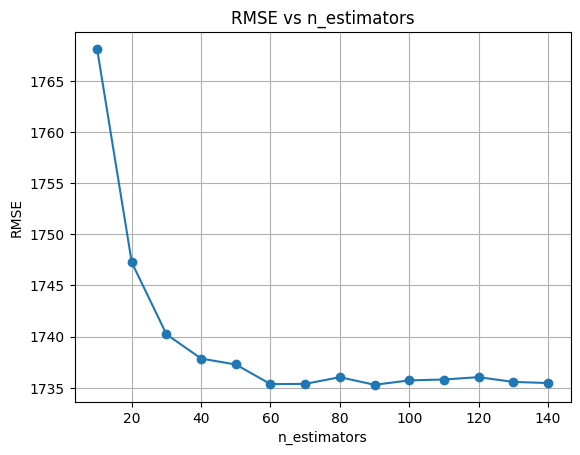

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Lista de valores de n_estimators a probar
estimator_range = range(10, 150, 10)

# Lista para almacenar RMSE promedio en validación cruzada
rmse_scores = []

for n in estimator_range:
    reg = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)

    # Validación cruzada con RMSE como métrica
    scores = cross_val_score(reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

    # Convertimos el error negativo en RMSE
    rmse_scores.append(np.sqrt(-scores.mean()))

# Mejor número de estimadores
best_n_estimators = estimator_range[np.argmin(rmse_scores)]
print(f"Mejor valor de n_estimators: {best_n_estimators}")

# Graficar RMSE vs. n_estimators
plt.plot(estimator_range, rmse_scores, marker='o')
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.title("RMSE vs n_estimators")
plt.grid(True)
plt.show()


Mejor valor de max_features: 9


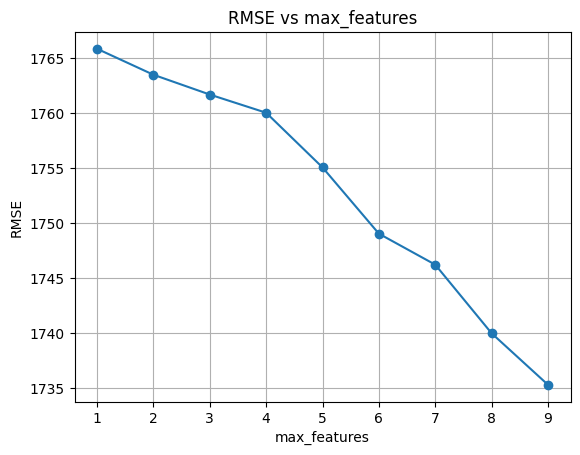

In [ ]:
# Lista de valores de max_features a probar
feature_range = range(1, X_train.shape[1] + 1)

# Lista para almacenar RMSE promedio en validación cruzada
rmse_scores = []

for feature in feature_range:
    reg = RandomForestRegressor(n_estimators=best_n_estimators, max_features=feature, random_state=1, n_jobs=-1)

    scores = cross_val_score(reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

    rmse_scores.append(np.sqrt(-scores.mean()))

# Mejor max_features
best_max_features = feature_range[np.argmin(rmse_scores)]
print(f"Mejor valor de max_features: {best_max_features}")

# Graficar RMSE vs. max_features
plt.plot(feature_range, rmse_scores, marker='o')
plt.xlabel("max_features")
plt.ylabel("RMSE")
plt.title("RMSE vs max_features")
plt.grid(True)
plt.show()


Mejor valor de max_depth: 9


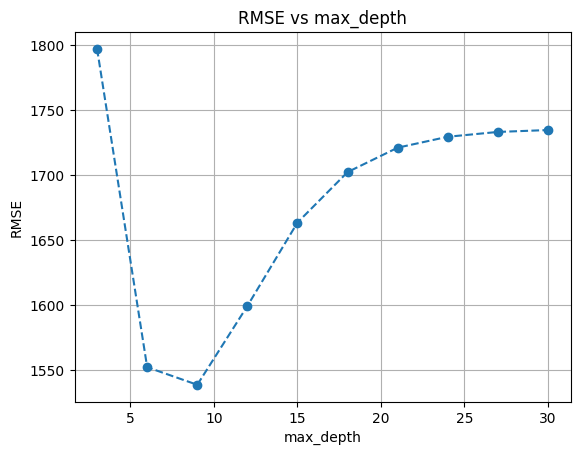

In [ ]:
# Lista de valores de max_depth a probar
depth_range = range(3, 31, 3)

# Lista para almacenar RMSE promedio en validación cruzada
rmse_scores = []

for depth in depth_range:
    reg = RandomForestRegressor(n_estimators=best_n_estimators,
                                max_features=best_max_features,
                                max_depth=depth,
                                random_state=1, n_jobs=-1)

    scores = cross_val_score(reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

    rmse_scores.append(np.sqrt(-scores.mean()))

# Mejor max_depth
best_max_depth = depth_range[np.argmin(rmse_scores)]
print(f"Mejor valor de max_depth: {best_max_depth}")

# Graficar RMSE vs. max_depth
plt.plot(depth_range, rmse_scores, marker='o', linestyle='dashed')
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.title("RMSE vs max_depth")
plt.grid(True)
plt.show()


In [ ]:
# Importar la librería
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Entrenar el modelo con los mejores hiperparámetros
best_rf = RandomForestRegressor(n_estimators=best_n_estimators, max_features=best_max_features, max_depth=best_max_depth, random_state=1, n_jobs=-1)

best_rf.fit(X_train, y_train)

# Predicciones
y_pred = best_rf.predict(X_test)

# Evaluación del modelo
rmseCal = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE del modelo optimizado: {rmseCal:.4f}")
print(f"R² del modelo optimizado: {r2:.4f}")


RMSE del modelo optimizado: 1568.6239
R² del modelo optimizado: 0.8391


In [ ]:
# Get feature names from X_train columns
feature_cols = X_train.columns

pd.DataFrame({'feature': feature_cols, 'importance': best_rf.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000265
3,M_Camry4dr,0.000486
5,M_CamryL,0.000645
7,M_CamrySE,0.003527
2,M_Camry,0.007812
6,M_CamryLE,0.008547
8,M_CamryXLE,0.017119
1,Mileage,0.173089
0,Year,0.788510


Análisis de Resultados

1. ¿Como cada parametro puede afectar al modelo?

* **N-estimadores (Cantidad de árboles usados en el modelo)**

    Aunque la seleccíón de la cantidad de N-estimadores en un Random forest puede ser más rapido, puede ser menos preciso frente a la construcción del modelo y sus iteraciones. Mientras qué donde la cantidad de arboles es mayor, será más preciso pero será más lento.
    
    El valor obtenido para el caso de los N-estimadores fue de 90 en su punto minimo segun la carateristica de RMSE. Esto nos indica que al aunmentar la cantidad de arboles sobre el modelo disminuye la raiz del error cuadratico que fue evaluado. Por lo que entre más abajo este determina que tan cercano estan las predicciones.

* **max_features (El máximo de Características usadas en el modelo)**

    Con respecto a la cantidad maxima de Catacterísticas a usar dentro del modelo, el RMSE disminiye, lo que atribuye que el modelo mejora con respecto a más variables a considerar dentro del modelo. Esto permite reducir el error en su predicción

* **max_depth (Profundidad máxima de los árboles)**

    La profundidad maxima de los arboles nos puede dar un menor sobre ajuste y  menos varianza (mientras que la profundidad sea pequeña). Por lo que la cantidad maxima de profundidad nos puede brindar relaciones más complejtas, lo que atribuye menos sesgo sobre los datos. En este caso como evidencio la gráfica, se muestra que la cantidad maxima optima esta dentro de los 6 y 9 niveles de profundidad.

* **Variables relevantes sobre el modelo de regresión**

    Los datos obtenidos sobre las variables relevantes que atribuyen una gran importancia sobre la predicción del modelo, son Year (mayoritariamente) y Mileage. lo que nos indica que son caracteristica diferenciadoras sobre el modelo. permitiendo suponer que el año del vehiculo atribuye más en su predicción.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6: Implementación de XGBoost para regresión

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Crear el modelo XGBoost para regresión
xgb_regressor = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Entrenar el modelo
xgb_regressor.fit(X_train, y_train)

# Realizar predicciones
y_pred = xgb_regressor.predict(X_test)

# Evaluar el desempeño del modelo
rmse_xgb = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE del modelo XGBoost: {rmse_xgb:.4f}")
print(f"R² del modelo XGBoost: {r2:.4f}")




RMSE del modelo XGBoost: 1563.2980
R² del modelo XGBoost: 0.8402


- Análisis de Resultados

Según los datos obtenidos sobre RMSE y R² del modelo XGBoost, se puede analizar el error promedio de las predicciones. Si el RMSE es menor, el modelo tendrá un mejor desempeño, especialmente en comparación con otros modelos. Para reducir este error y evitar el overfitting, es posible calibrar el modelo ajustando sus hiperparámetros de entrada.

Mientras que el R² obtenido fue de 0.8402, lo que explica el porcentaje de variabilidad de los datos que el modelo captura. Esto nos indica que aproximadamente el 84% de la variabilidad en los datos está siendo explicada, lo que refleja un buen ajuste.

Por otro lado, el RMSE del modelo XGBoost es de 1563.30, lo que indica que, en promedio, las predicciones tienen un margen de error de aproximadamente 1563 unidades respecto a los valores reales. Aunque este valor es relativamente bajo, aún hay margen para optimizarlo mediante ajustes en el modelo.

### Punto 7 - Calibración de Parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Se genera un error de compatibilidad con la librería de scikit-learn & XGboost, por lo cual se hace uso de la Librería de XGboost que no depende de scikit-learn.

In [ ]:
# Celda 7
# Convertir los datos a formato DMatrix, que proviende de la librería de XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Combinaciones de hiperparámetros
learning_rates = [0.01, 0.05, 0.1, 0.2]
gammas = [0, 0.5, 1, 2]
colsample_bytree_vals = [0.3, 0.5, 0.7, 1.0]

results = []

# Bucle para recorrer cada combinación posible
for lr in learning_rates:
    for gm in gammas:
        for cs in colsample_bytree_vals:

            # Definimos el modelo con los parámetros actuales
            params = {
                "objective": "reg:squarederror",   # función de pérdida para regresión
                "learning_rate": lr,               # tasa de aprendizaje
                "gamma": gm,                       # regularización por división
                "colsample_bytree": cs,            # % columnas a usar por árbol
                "max_depth": 6,                    # fijo como en el punto anterior
                "seed": 42
            }

            # Validación cruzada usando xgb.cv()
            cv_result = xgb.cv(
                params=params,
                dtrain=dtrain,
                num_boost_round=100,
                nfold=5,
                metrics='rmse',
                early_stopping_rounds=10,
                seed=42,
                as_pandas=True,
                verbose_eval=False
            )

            # Extraer el menor RMSE de esa combinación
            min_rmse = cv_result['test-rmse-mean'].min()
            results.append((lr, gm, cs, min_rmse))

# DataFrame para analizar
results_df = pd.DataFrame(results, columns=['learning_rate', 'gamma', 'colsample_bytree', 'RMSE'])
best_row = results_df.loc[results_df["RMSE"].idxmin()]
print("Mejores hiperparámetros encontrados:")
print(best_row)

Mejores hiperparámetros encontrados:
learning_rate          0.050000
gamma                  0.000000
colsample_bytree       0.700000
RMSE                1504.470788
Name: 18, dtype: float64


In [ ]:
# Modelo optimizado de XGBoost
xgb_final = xgb.XGBRegressor(
    objective="reg:squarederror",
    learning_rate=0.2,
    gamma=0.0,
    colsample_bytree=0.7,
    max_depth=6,
    n_estimators=100,
    random_state=42
)

# Entrenar con los datos de entrenamiento
xgb_final.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = xgb_final.predict(X_test)

# Evaluar desempeño
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))
r2_final = r2_score(y_test, y_pred)

print(f"Desempeño del modelo XGBoost optimizado:")
print(f"RMSE: {rmse_final:.2f}")
print(f"R²:   {r2_final:.4f}")

Desempeño del modelo XGBoost optimizado:
RMSE: 1564.45
R²:   0.8400


- Análisis de Resultados

Cada combinación se evaluó con 100 árboles (para mantener un buen tiempo computacional sin caer en modelos subentrenados), se evaluó con la métrica de RMSE en validación cruzada y un early_stopping_rounds = 10 para detenerse si el modelo deja de mejorar.
Se usan esos valores con base a los ratios que pueden tomar cada parámetro, tales como learning_rate = [0.01, 0.3], gamma = [0, 0.5, 1, 2] y colsample_bytree = [0.3, 0.5, 0.7, 1.0] (donde 1 significa que se usan todas las variables).

1. learning_rate (0.2): un valor más alto permite converger más rápido y generar árboles más expresivos sin sobreajuste, debido al early_stopping_rounds.
2. gamma (0.0): LA parecer no fue necesario penalizar la complejidad del árbol.
3. colsample_bytree (0.7): indica que solo se usa un 70% de las variables de cada árbol ayudando a reducir sobreajuste y mejorar generalización.

XG Boost con la calibración de hiperparámetros tales como learning_rate, gamma, colsample_bytree, n_estimators, marca la diferencia y puede reducir el error considerablemente.

### Punto 8 - Comparación y Conclusiones Finales
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

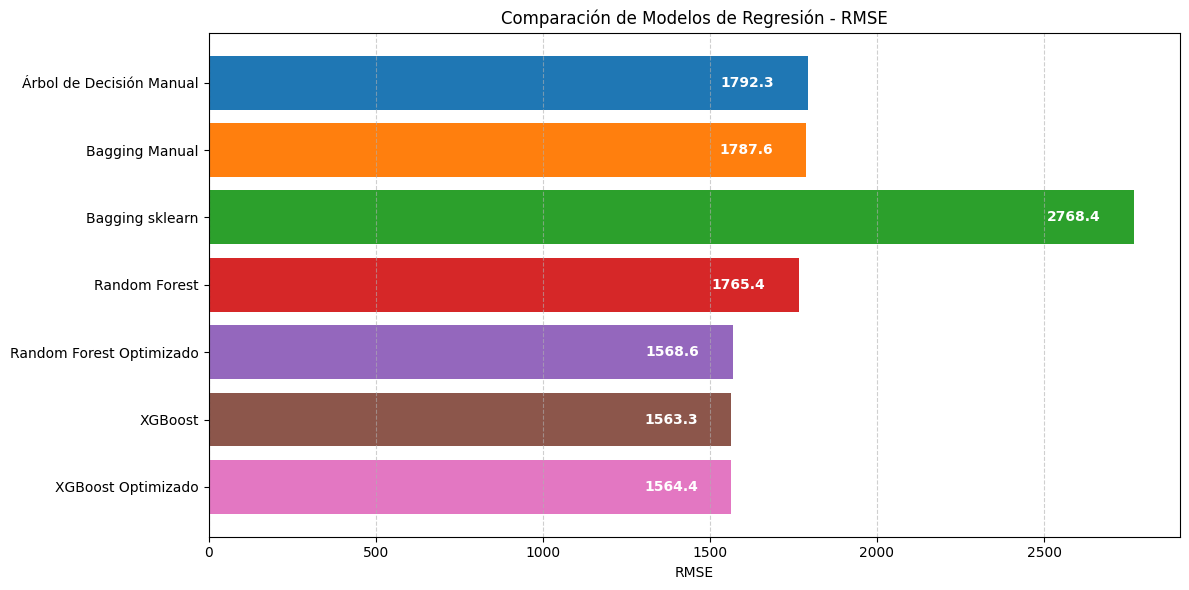

In [ ]:
# Celda 8
nombres_modelos = [
    "Árbol de Decisión Manual",
    "Bagging Manual",
    "Bagging sklearn",
    "Random Forest",
    "Random Forest Optimizado",
    "XGBoost",
    "XGBoost Optimizado"
]

# Valores reales de RMSE
valores_rmse = [
    rmse_mixed,     # Árbol manual
    rmseManual,        # Bagging manual
    rmse_bagging,   # Bagging sklearn
    rmse_rf,        # RF básico
    rmseCal,        # RF optimizado
    rmse_xgb,       # XGB básico
    rmse_final      # XGB optimizado
]

colores = plt.cm.tab10.colors[:len(nombres_modelos)]
plt.figure(figsize=(12, 6))
bars = plt.barh(nombres_modelos, valores_rmse, color=colores)

for bar in bars:
    plt.text(
        bar.get_width() - 100,                     # posición horizontal del texto
        bar.get_y() + bar.get_height() / 2,        # posición vertical centrada
        f'{bar.get_width():.1f}',                  # valor con 1 decimal
        va='center',
        ha='right',
        color='white',
        fontsize=10,
        fontweight='bold'
    )

plt.xlabel("RMSE")
plt.title("Comparación de Modelos de Regresión - RMSE")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

El mejor Modelo es XGBoost puesto que tiene el menor RMSE, destaca por su robustez y rapidez. Aún sin mucha calibración, ofrece excelente rendimiento.
Los modelos Optimizados (Random Forest y XGBoost) logran RMSE competitivos, la calibración de hiperparámetros fue útil, aunque no superaron al XGBoost base.

El Bagging con sklearn sin calibración presenta un RMSE muy alto, reflejando que sin una adecuada configuración, el modelo no es competitivo.Necesita ajustes finos en max_features, número de árboles, etc.

El Árbol de decisión manual, a pesar de su simplicidad, sirve como punto de partida.